In [1]:
import numpy as np
import matplotlib.pyplot as plt
from toymodel_update import toymodel_update
from water_energy_variables import water_energy_variables
from weighted_average_outputs import weighted_average_outputs
from aggregate import aggregate, make_means_new, make_means, make_monthly_new
import pandas as pd
from Rso_calc import Rso_calc
from plotter import plot_gSM, plot_FDC, plot_FFC

# 1 - Load Data
Q_path = r"Data\Q_mm.csv"
e_path = r"Data\e.csv"
L_net_path = r"Data\L_net.csv"
Lat_long_path = r"Data\Lat_Lon_Area_Z.csv"
Precip_path = r"Data\Precip.csv"
S_in_path = r"Data\S_in.csv"
Temp_path = r"Data\Temp.csv"
u2_path = r"Data\u2.csv"
dates_path = r"Data\Dates.csv"

# 1 - Load Data
Q = np.genfromtxt(Q_path, delimiter=',')[:, 3:]  # Q in mm
Dates = np.genfromtxt(dates_path, delimiter=',')[:, 0:3]
Precip = np.genfromtxt(Precip_path, delimiter=',')[:, 3:]  # P in mm
e = np.genfromtxt(e_path, delimiter=',')[:, 3:]  # e in kPa
u2 = np.genfromtxt(u2_path, delimiter=',')[:, 3:]  # u2 in m/s
S_in = np.genfromtxt(S_in_path, delimiter=',')[:, 3:]  # S_in in W/m^2
Temp = np.genfromtxt(Temp_path, delimiter=',')[:, 3:]  # Temp in deg C
Lat_Lon_A_Z = np.genfromtxt(Lat_long_path, delimiter=',')  # Lat, Lon, Area, Z

# Assuming Rso_calc function is properly imported and used in the code
Ra, Rso = Rso_calc(Dates, Lat_Lon_A_Z[:, 0], Lat_Lon_A_Z[:, 1], Lat_Lon_A_Z[:, 3])

# Conversion to W/m2
Rso = Rso / (1e-6 * 60 * 60 * 24)
Ra = Ra / (1e-6 * 60 * 60 * 24)

f = 1.35 * (S_in / Rso) - 0.35
e_prime = 0.34 - 0.14 * np.sqrt(e / 1000)
L_net = -f * e_prime * 5.67e-8 * (Temp + 273.15)**4

# Penman-Monteith calculation (lambda function converted to a standard function)
def Penman_Monteith_calc(Delta, A, rho_a, c_p, VPD, ra, gamma, rs):
    return (Delta * A + rho_a * c_p * VPD / ra) / (Delta + gamma * (1 + rs / ra))

cp = 1.1013e3  # J/(kg.K)
lambda_ = 1000 * (2.501 - 0.002361 * Temp)
rho_air = 1.23  # kg/m3

ra = 208 / u2
rs = 70
Rn_RC = S_in * (1 - 0.23) + L_net
e_sat = 0.6108 * np.exp((17.27 * Temp) / (237.3 + Temp))
D = e_sat - e
Delta = 4098 * e_sat / (237.3 + Temp)**2
Z = Lat_Lon_A_Z[:, 3]
Press = 101.3 * ((293 - 0.0065 * Z) / 293)**5.26
gamma = cp * Press / (0.622 * lambda_ * 1000)

Wm2_mm = (lambda_ * 1000)**-1 * 86400

E_RC = (Delta * Rn_RC + rho_air * cp * D / ra) / (Delta + gamma * (1 + rs / ra))
E_RC_mm = E_RC * Wm2_mm  # Convert to mm/day
Rn_RC_mm = Rn_RC * Wm2_mm  # Convert to mm/day

# 2.3 Pick a catchment
pick_catchment = 10

# 3.1 Mean annual analysis
n_years = len(np.unique(Dates[:, 0]))

PET_MEAN_MONTHLY, PET_MEAN_ANNUAL = make_means_new(E_RC_mm, Dates)
Q_MEAN_MONTHLY, Q_MEAN_ANNUAL = make_means_new(Q, Dates)
P_MEAN_MONTHLY, P_MEAN_ANNUAL = make_means_new(Precip, Dates)
Temp_MEAN_MONTHLY, Temp_MEAN_ANNUAL = make_means(Temp, Dates)

PHI = PET_MEAN_ANNUAL / P_MEAN_ANNUAL
E_P = (P_MEAN_ANNUAL - Q_MEAN_ANNUAL) / P_MEAN_ANNUAL

# Budyko plot
AI_plot_lin = np.arange(0.01, 50.01, 0.01)
Budyko = lambda AI: (AI * (1 - np.exp(-AI)) * np.tanh(1 / AI))**0.5




In [2]:
# 3.2 Run Hydrologic Model
INPUT = np.zeros((Precip.shape[0], 7))
INPUT[:, 0] = Precip[:, pick_catchment - 1]  # Adjusting for 0-based indexing
INPUT[:, 1] = E_RC_mm[:, pick_catchment - 1]
INPUT[:, 2] = e[:, pick_catchment - 1]
INPUT[:, 3] = u2[:, pick_catchment - 1]
INPUT[:, 4] = S_in[:, pick_catchment - 1]
INPUT[:, 5] = Temp[:, pick_catchment - 1]
INPUT[:, 6] = L_net[:, pick_catchment - 1]
Dates_sim = Dates

# Assuming water_energy_variables function is defined
vars_forest = water_energy_variables(1)
vars_grass = water_energy_variables(2)

# 3.3 Simulation 1
PAR = [50, 232,  20,   1]  # Parameters array

# PAR(0) Maximum infiltration rate  [300]
# PAR(1) Su_max - total water capacity [50-300]
# PAR(2) Ts time - parameter for slowflow [20-100]
# PAR(3) Tf time = parameter for quickflow [1-3]
Su_max = PAR[1]

vars_1A = vars_forest.copy()
vars_1A['Patm'] = Press[pick_catchment - 1]  # Assuming Press is an array
vars_1A['g0'] = 10
vars_1A['z0'] = 0.826
vars_1A['a'] = 0.12
vars_1A['FC'] = 0.35 * Su_max
vars_1A['WP'] = 0.11 * Su_max


vars_1B = vars_grass.copy()
vars_1B['Patm'] = Press[pick_catchment - 1]
vars_1B['g0'] = 3
vars_1B['z0'] = 0.24
vars_1B['a'] = 0.25
vars_1B['FC'] = 0.35 * Su_max
vars_1B['WP'] = 0.11 * Su_max
PAR1B = PAR.copy()
PAR1B[0] = 25

OUT_1A = toymodel_update(INPUT, PAR, vars_1A)
OUT_1B = toymodel_update(INPUT, PAR1B, vars_1B)

weight_1A = 0.9
weight_1B = 0.1

OUT_1 = weighted_average_outputs(OUT_1A, OUT_1B, weight_1A, weight_1B)
OUT_1 = aggregate(OUT_1, Dates_sim)


PHI_SIM_1 = OUT_1['PET_mean_annual'] / OUT_1['P_mean_annual']
EF_SIM_1 = (OUT_1['P_mean_annual'] - OUT_1['QT_mean_annual']) / OUT_1['P_mean_annual']


Q_SIM_mean_monthly = OUT_1['QT_mean_mon']
Q_SIM = OUT_1['QT']
plot_from = 1000
plot_to = 1300
# 3.4 Simulation 2
vars_2A = vars_forest.copy()
vars_2A['Patm'] = Press[pick_catchment - 1]  
vars_2A['g0'] = 10
vars_2A['z0'] = 0.83
vars_2A['a'] = 0.12
vars_2A['FC'] = 0.38 * Su_max
vars_2A['WP'] = 0.11 * Su_max

vars_2B = vars_grass.copy()
vars_2B['Patm'] = Press[pick_catchment - 1]
vars_2B['g0'] = 3
vars_2B['z0'] = 0.24
vars_2B['a'] = 0.25
vars_2B['FC'] = 0.38 * Su_max
vars_2B['WP'] = 0.11 * Su_max

PAR2B = PAR.copy()
PAR2B[0] = 25

weight_2A = 0.1
weight_2B = 0.9

# Assuming toymodel_update function is defined
OUT_2A = toymodel_update(INPUT, PAR, vars_2A)
OUT_2B = toymodel_update(INPUT, PAR2B, vars_2B)

# Assuming weighted_average_outputs function is defined
OUT_2 = weighted_average_outputs(OUT_2A, OUT_2B, weight_2A, weight_2B)
OUT_2 = aggregate(OUT_2, Dates_sim)

PHI_SIM_2 = OUT_2['PET_mean_annual'] / OUT_2['P_mean_annual']
EF_SIM_2 = (OUT_2['P_mean_annual'] - OUT_2['QT_mean_annual']) / OUT_2['P_mean_annual']


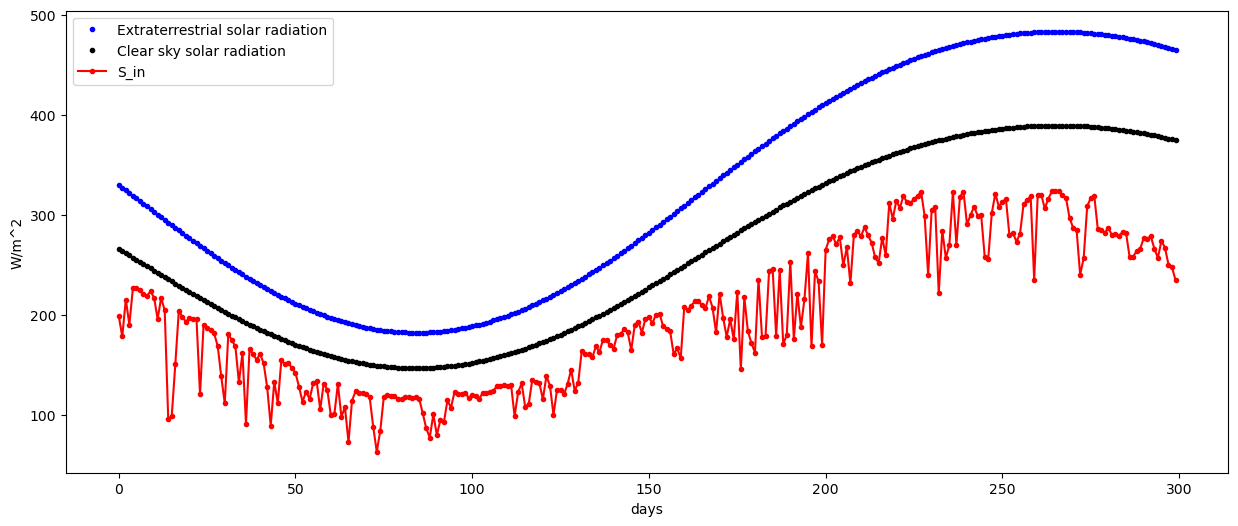

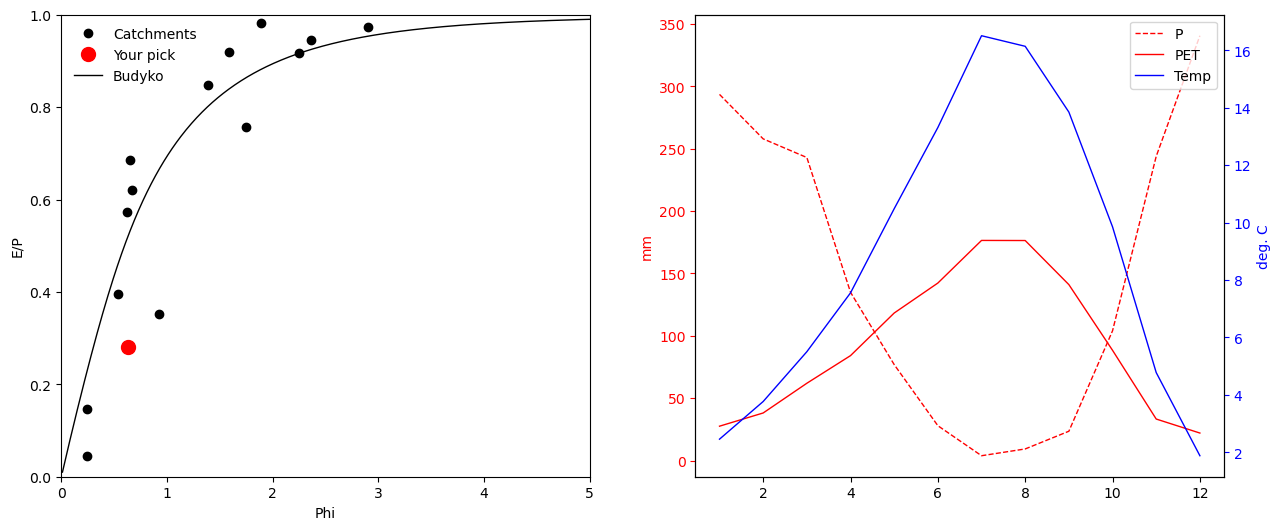

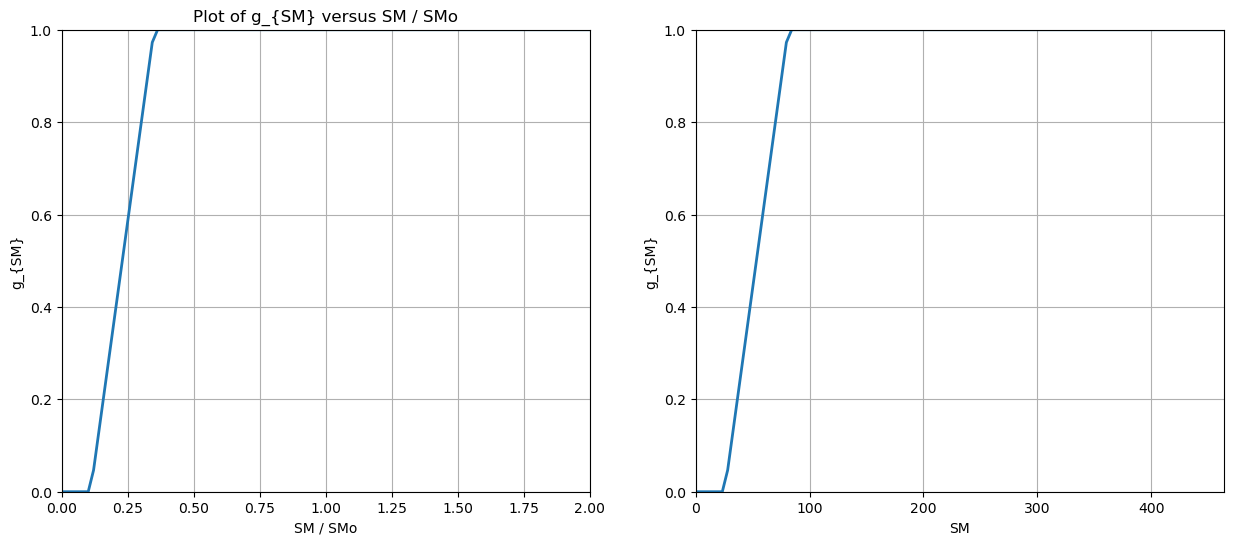

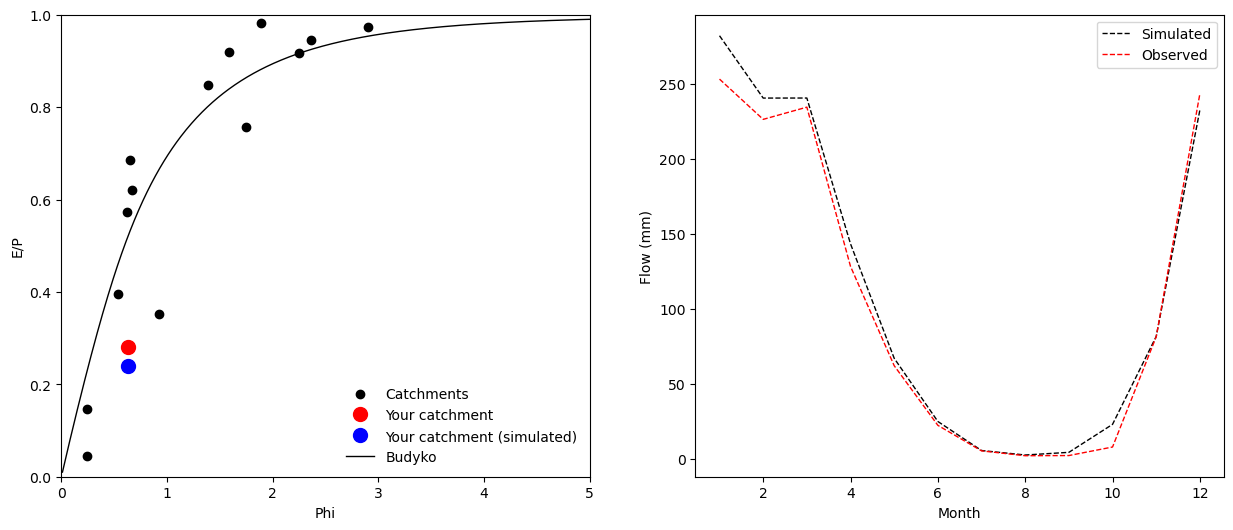

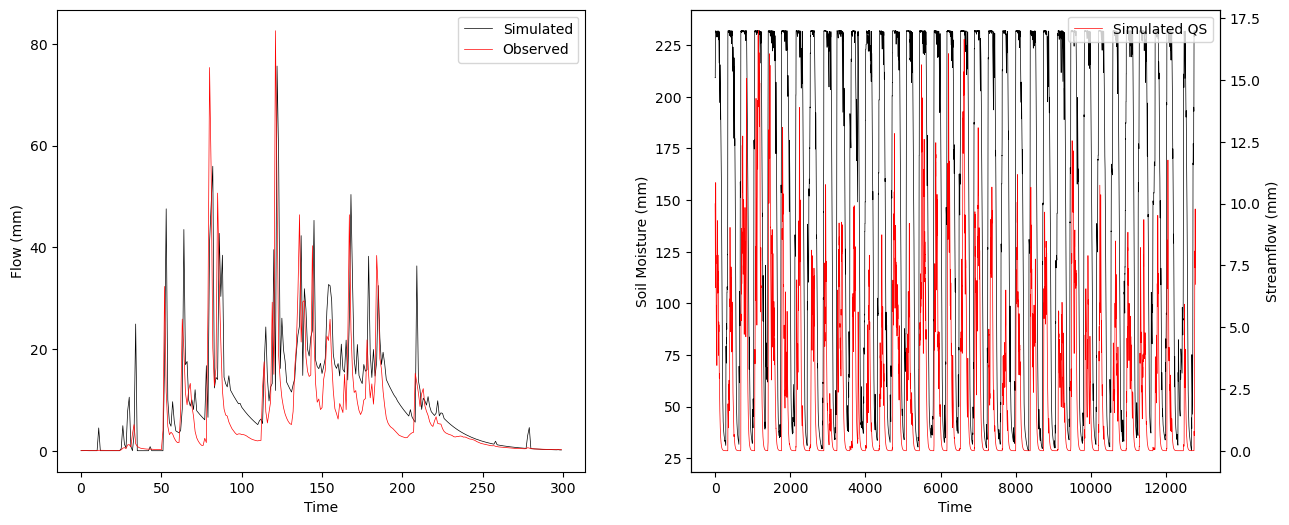

In [3]:
import matplotlib.pyplot as plt


plot_from = 1000
plot_to = 1300
chose = 15

# Figure 1 Solar radiation
plt.figure(1, figsize=(15, 6))
plt.clf()
plt.plot(Ra[plot_from:plot_to, chose - 1], '.b', label='Extraterrestrial solar radiation')
plt.plot(Rso[plot_from:plot_to, chose - 1], '.k', label='Clear sky solar radiation')
plt.plot(S_in[plot_from:plot_to, chose - 1], '.-r', label='S_in')
plt.legend()
plt.ylabel('W/m^2')
plt.xlabel('days')

# Figure 2
# Subplot 1: Budyko plot for observed data
plt.figure(2, figsize=(15, 6))
plt.clf()
plt.subplot(1, 2, 1)
plt.plot(PHI, E_P, 'ok', linewidth=1, label='Catchments')
plt.plot(PHI[pick_catchment - 1], E_P[pick_catchment - 1], '.r', markersize=20, label='Your pick')
plt.plot(AI_plot_lin, Budyko(AI_plot_lin), 'k-', linewidth=1, label='Budyko')
plt.legend(frameon=False)
plt.ylabel('E/P')
plt.xlabel('Phi')
plt.axis([0, 5, 0, 1])
# Subplot 2: Monthly comparison of P, PET, and Temp
plt.subplot(1, 2, 2)
# Plotting on the primary y-axis
plt.plot(range(1, 13), P_MEAN_MONTHLY[:, pick_catchment - 1], '--r', linewidth=1, label='P')
plt.plot(range(1, 13), PET_MEAN_MONTHLY[:, pick_catchment - 1], '-r', linewidth=1, label='PET')
plt.ylabel('mm', color='r')
ax1 = plt.gca() # Set the color of the y-axis label and tick labels to red
ax1.tick_params(axis='y', colors='r')
handles1, labels1 = ax1.get_legend_handles_labels() # Save the handles and labels of the first axis
ax2 = plt.twinx() # Create secondary y-axis and plot
ax2.plot(range(1, 13), Temp_MEAN_MONTHLY[:, pick_catchment - 1], '-b', linewidth=1, label='Temp')
plt.ylabel('deg. C', color='b')
ax2.tick_params(axis='y', colors='b') # Set the color of the secondary y-axis label and tick labels to blue
handles2, labels2 = ax2.get_legend_handles_labels() # Save the handles and labels of the second axis
handles = handles1 + handles2 # Combine handles and labels from both axes
labels = labels1 + labels2
plt.legend(handles, labels, loc='best')
plt.xlabel('Month')

# Figure 3 Plot soil moisture
plot_gSM(vars_1A['FC'], vars_1A['WP'], Su_max)

# Figure 4 
# Subplot 1: Budyko plot for observed and simulated data
plt.figure(4, figsize=(15, 6))
plt.clf()
plt.subplot(1, 2, 1)
plt.plot(PHI, E_P, 'ok', linewidth=1, label='Catchments')
plt.plot(PHI[pick_catchment - 1], E_P[pick_catchment - 1], '.r', markersize=20, label='Your catchment')
plt.plot(PHI_SIM_1, EF_SIM_1, '.b', markersize=20, label='Your catchment (simulated)')
plt.plot(AI_plot_lin, Budyko(AI_plot_lin), 'k-', linewidth=1, label='Budyko')
plt.legend(loc='best', frameon=False)
plt.ylabel('E/P')
plt.xlabel('Phi')
plt.axis([0, 5, 0, 1])
# Subplot 2: Monthly flow comparison
plt.subplot(1, 2, 2)
plt.plot(range(1, 13), Q_SIM_mean_monthly, '--k', linewidth=1, label='Simulated')
plt.plot(range(1, 13), Q_MEAN_MONTHLY[:, pick_catchment - 1], '--r', linewidth=1, label='Observed')
plt.xlabel('Month')  # Label for the x-axis
plt.ylabel('Flow (mm)')  # Label for the y-axis; replace 'unit' with the appropriate unit of flow
plt.legend()

#Figure 5
plt.figure(5, figsize=(15, 6))
plt.clf()
# Subplot 1: Flow Time Series
plt.subplot(1, 2, 1)
plt.plot(Q_SIM[plot_from:plot_to], '-k', linewidth=0.5, label='Simulated')
plt.plot(Q[plot_from:plot_to, pick_catchment - 1], '-r', linewidth=0.5, label='Observed')
plt.xlabel('Time')  # X-axis label
plt.ylabel('Flow (mm)')  # Y-axis label
plt.legend()

# Subplot 2: Soil Moisture and Streamflow
plt.subplot(1, 2, 2)
plt.plot(OUT_1['Su'], '-k', linewidth=0.5, label='Simulated Su')
plt.xlabel('Time')  # X-axis label
plt.ylabel('Soil Moisture (mm)')  # Primary Y-axis label
ax2 = plt.twinx()
plt.plot(OUT_1['QS'], '-r', linewidth=0.5, label='Simulated QS')
ax2.set_ylabel('Streamflow (mm)')  # Secondary Y-axis label
plt.legend()

plt.show()


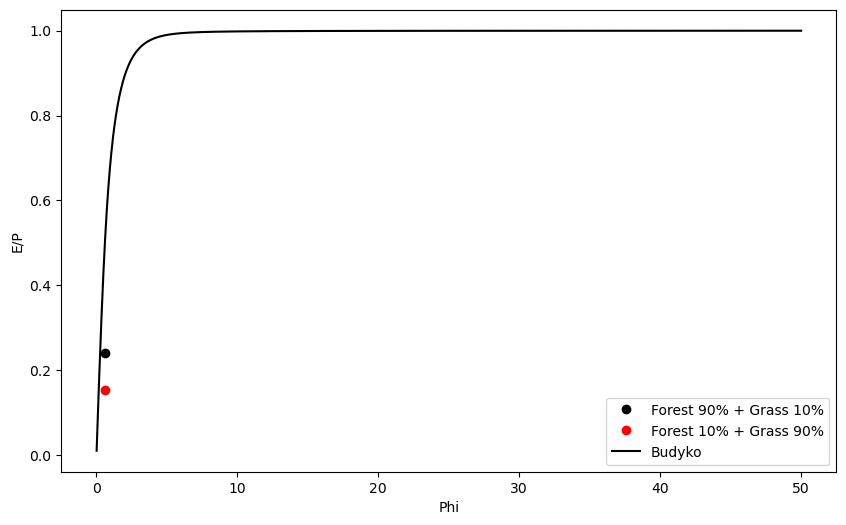

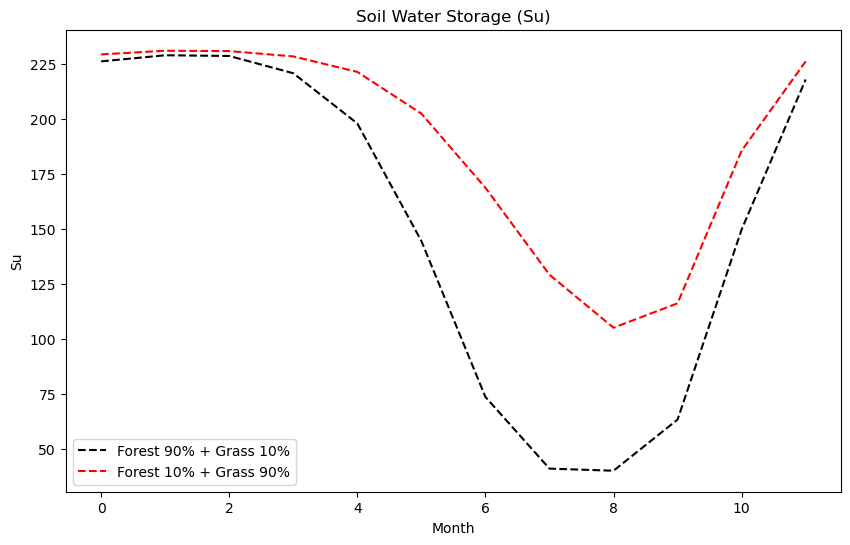

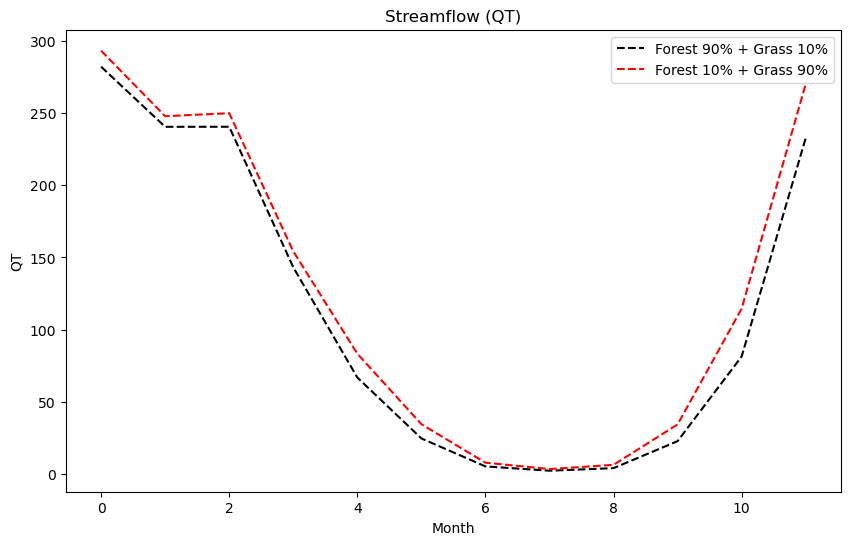

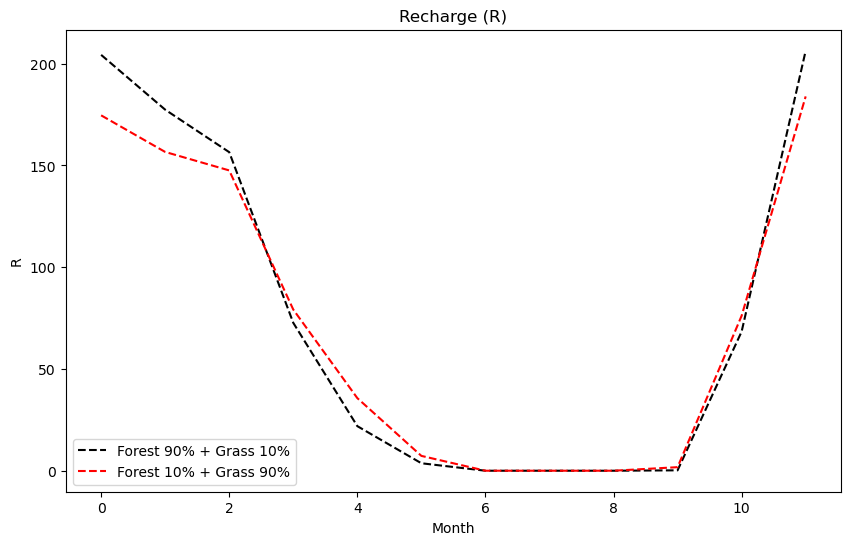

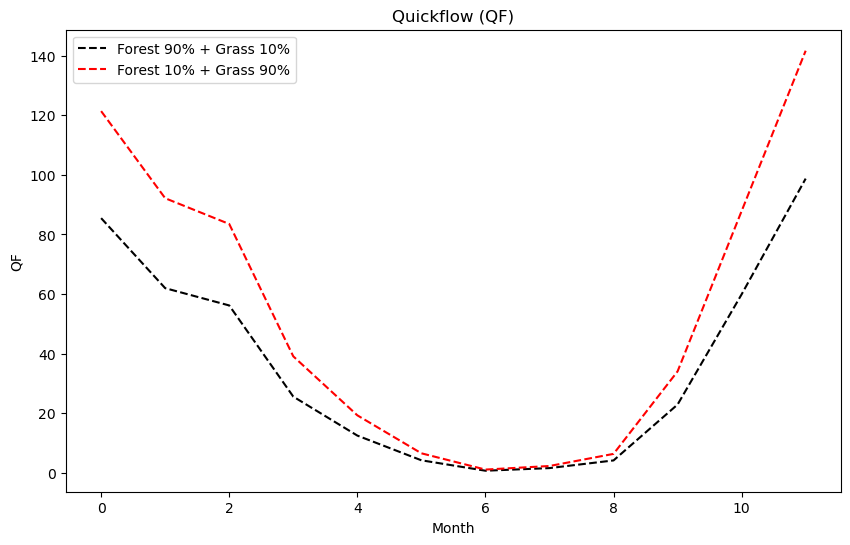

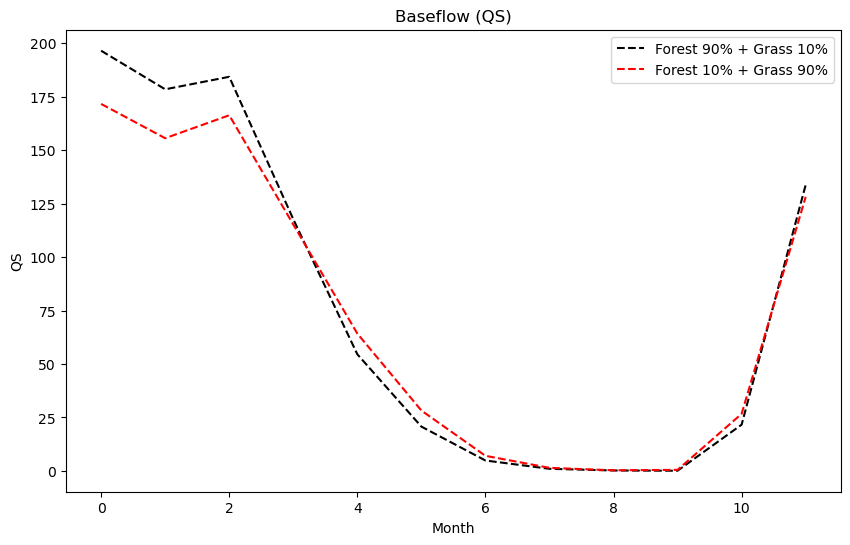

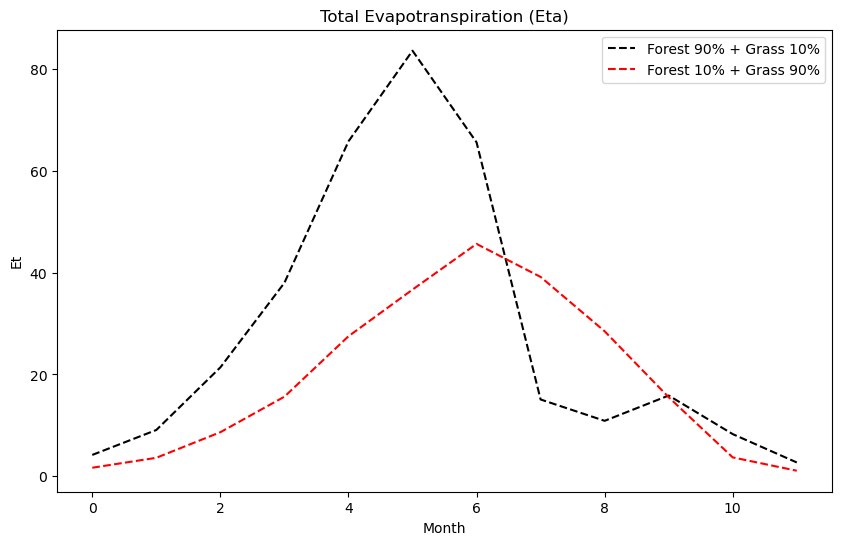

In [4]:

sim1_label = 'Forest 90% + Grass 10%'
sim2_label = 'Forest 10% + Grass 90%'


#Plot E_P_SIM_1 vs PHI_SIM1 and E_P_SIM_2 vs PHI_SIM2
plt.figure(figsize=(10, 6))
plt.plot(PHI_SIM_1, EF_SIM_1, 'ok', label= sim1_label)
plt.plot(PHI_SIM_2, EF_SIM_2, 'or', label= sim2_label)
plt.plot(AI_plot_lin, Budyko(AI_plot_lin), 'k-', label='Budyko')
plt.xlabel('Phi')
plt.ylabel('E/P')
plt.legend()
plt.show()


def plot_monthly_comparison(variable, title, OUT_1, OUT_2, label_1= sim1_label, label_2= sim2_label):
    plt.figure(figsize=(10, 6))
    plt.plot(OUT_1[variable + '_mean_mon'], '--k', label=label_1)  # Plot monthly data for simulation 1
    plt.plot(OUT_2[variable + '_mean_mon'], '--r', label=label_2)  # Plot monthly data for simulation 2
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel(variable)
    plt.legend()
    plt.show()

plot_monthly_comparison('Su', 'Soil Water Storage (Su)', OUT_1, OUT_2)
plot_monthly_comparison('QT', 'Streamflow (QT)', OUT_1, OUT_2)
plot_monthly_comparison('R', 'Recharge (R)', OUT_1, OUT_2)
plot_monthly_comparison('QF', 'Quickflow (QF)', OUT_1, OUT_2)
plot_monthly_comparison('QS', 'Baseflow (QS)', OUT_1, OUT_2)
plot_monthly_comparison('Et', 'Total Evapotranspiration (Eta)', OUT_1, OUT_2)




In [5]:

plot_FDC(data = OUT_1['QT'], OUT_2['QT'], labels = [sim1_label, sim2_label])

# Prepare the datetime index for plotting
Dates_sim_dt = pd.to_datetime({'year': Dates_sim[:, 0].astype(int), 
                               'month': Dates_sim[:, 1].astype(int), 
                               'day': Dates_sim[:, 2].astype(int)})

fig, ax = plt.subplots()
plot_FFC(Dates_sim_dt, OUT_1['QT'], sim1_label, ax)
plot_FFC(Dates_sim_dt, OUT_2['QT'], sim2_label, ax)
plt.title('Flood Frequency Curve Comparisons')
plt.show()

NameError: name 'sim1_label' is not defined

<Figure size 1000x400 with 0 Axes>

In [ ]:
def print_monthly_values(variable, OUT_1, OUT_2, interval_count=1):
    data_1 = OUT_1[variable + '_mean_mon']
    data_2 = OUT_2[variable + '_mean_mon']
    interval_length_1 = len(data_1) // interval_count
    interval_length_2 = len(data_2) // interval_count

    print(f"{sim1_label} {variable} Data Points:")
    for i in range(0, len(data_1), interval_count):
        print(f"Month {i+1}: {data_1[i]}")

    print(f"\n{sim2_label} {variable} Data Points:")
    for i in range(0, len(data_2), interval_count):
        print(f"Month {i+1}: {data_2[i]}")


print_monthly_values('Su', OUT_1, OUT_2)
print_monthly_values('QT', OUT_1, OUT_2)
print_monthly_values('R', OUT_1, OUT_2)
print_monthly_values('QF', OUT_1, OUT_2)
print_monthly_values('QS', OUT_1, OUT_2)
print_monthly_values('Et', OUT_1, OUT_2)

print(f"{sim1_label} Data Points:")
print(f"Phi: {PHI_SIM_1:.2f}, E/P: {EF_SIM_1:.2f}")

print(f"\n{sim2_label} Data Points:")
print(f"Phi: {PHI_SIM_2:.2f}, E/P: {EF_SIM_2:.2f}")


Data Point 0: % of Time Exceeded: 7.822277847309137e-05, Q (mm/d): 2.3135344365702253e-07
Data Point 639: % of Time Exceeded: 0.05006257822277847, Q (mm/d): 0.0002953802198393033
Data Point 1278: % of Time Exceeded: 0.10004693366708385, Q (mm/d): 0.0011196569102535786
Data Point 1917: % of Time Exceeded: 0.15003128911138924, Q (mm/d): 0.003207771774983336
Data Point 2556: % of Time Exceeded: 0.20001564455569462, Q (mm/d): 0.008480995954086976
Data Point 3195: % of Time Exceeded: 0.25, Q (mm/d): 0.021809959418821804
Data Point 3834: % of Time Exceeded: 0.2999843554443054, Q (mm/d): 0.050969958471916654
Data Point 4473: % of Time Exceeded: 0.34996871088861076, Q (mm/d): 0.10660588466333593
Data Point 5112: % of Time Exceeded: 0.39995306633291616, Q (mm/d): 0.22369172972327178
Data Point 5751: % of Time Exceeded: 0.4499374217772215, Q (mm/d): 0.4766466838516932
Data Point 6390: % of Time Exceeded: 0.4999217772215269, Q (mm/d): 0.911475088327318
Data Point 7029: % of Time Exceeded: 0.54990

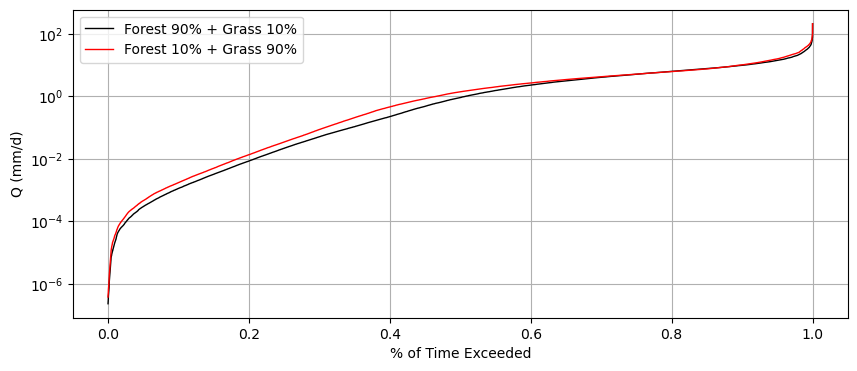

Data Point 0: Return Period (years): 35.0, Annual Maximum Streamflow (mm/d): 210.0
Data Point 1: Return Period (years): 17.5, Annual Maximum Streamflow (mm/d): 76.73841081766473
Data Point 2: Return Period (years): 11.666666666666666, Annual Maximum Streamflow (mm/d): 75.64754707851212
Data Point 3: Return Period (years): 8.75, Annual Maximum Streamflow (mm/d): 75.19422055181228
Data Point 4: Return Period (years): 7.0, Annual Maximum Streamflow (mm/d): 74.10631862459012
Data Point 5: Return Period (years): 5.833333333333333, Annual Maximum Streamflow (mm/d): 73.22063763480888
Data Point 6: Return Period (years): 5.0, Annual Maximum Streamflow (mm/d): 63.438933842497086
Data Point 7: Return Period (years): 4.375, Annual Maximum Streamflow (mm/d): 59.76563267899026
Data Point 8: Return Period (years): 3.8888888888888893, Annual Maximum Streamflow (mm/d): 59.21410796511146
Data Point 9: Return Period (years): 3.5, Annual Maximum Streamflow (mm/d): 55.944614876224776
Data Point 10: Return

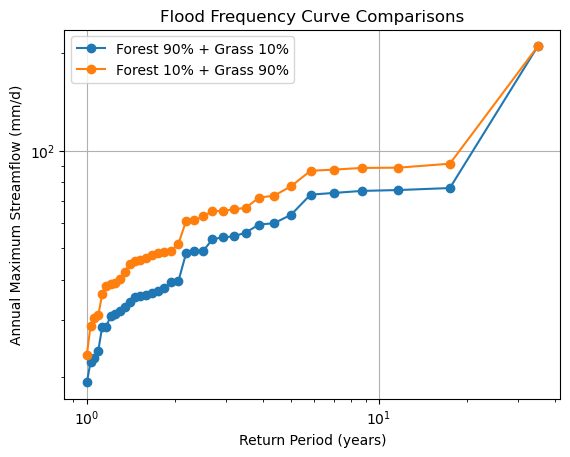

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_FDC(*args):
    plt.figure(4, figsize=(10, 4))  # Adjust figure size as needed
    plt.clf()

    for i, data in enumerate(args):
        QT_sorted = np.sort(data)[::-1]  # Sort data in descending order
        #sort data in ascending order
        QT_sorted = np.sort(data)
        permanence = np.arange(1, len(QT_sorted) + 1) / len(QT_sorted)  # Calculate permanence
        if i == 0:
            plt.semilogy(permanence, QT_sorted, '-k', linewidth=1, label=sim1_label)
        else:
            plt.semilogy(permanence, QT_sorted, '-r', linewidth=1, label=sim2_label)
        
        # Print data points at regular intervals
        interval = len(QT_sorted) // 20
        for j in range(0, len(QT_sorted), interval):
            print(f'Data Point {j}: % of Time Exceeded: {permanence[j]}, Q (mm/d): {QT_sorted[j]}')

    plt.ylabel('Q (mm/d)')
    plt.xlabel('% of Time Exceeded')
    plt.legend()
    plt.grid(True)
    plt.axis('tight')
    plt.show()


plot_FDC(OUT_1['QT'], OUT_2['QT'])

def plot_FFC(Dates, QT, label, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Convert Dates and QT to a pandas Series object
    QT_series = pd.Series(QT, index=Dates)

    # Group by year and get the annual maximum streamflow
    annual_max_flows = QT_series.groupby(QT_series.index.year).max()

    # Sort the annual maximum flows in descending order
    sorted_max_flows = annual_max_flows.sort_values(ascending=False)

    # Calculate exceedance probability and return periods
    n_years = len(sorted_max_flows)
    exceedance_prob = np.arange(1, n_years + 1) / n_years
    return_periods = 1 / exceedance_prob

    # Plotting
    ax.loglog(return_periods, sorted_max_flows, 'o-', label=label)
    ax.set_xlabel('Return Period (years)')
    ax.set_ylabel('Annual Maximum Streamflow (mm/d)')
    ax.grid(True)
    ax.legend()
    
    # Print data points at regular intervals
    interval = len(sorted_max_flows) // 20
    for i in range(0, len(sorted_max_flows), interval):
        print(f'Data Point {i}: Return Period (years): {return_periods[i]}, Annual Maximum Streamflow (mm/d): {sorted_max_flows.iloc[i]}')

# Prepare the datetime index for plotting
Dates_sim_dt = pd.to_datetime({'year': Dates_sim[:, 0].astype(int), 
                               'month': Dates_sim[:, 1].astype(int), 
                               'day': Dates_sim[:, 2].astype(int)})

# Create a figure for plotting
fig, ax = plt.subplots()
plot_FFC(Dates_sim_dt, OUT_1['QT'], sim1_label, ax)
plot_FFC(Dates_sim_dt, OUT_2['QT'], sim2_label, ax)
plt.title('Flood Frequency Curve Comparisons')
plt.show()
